# Action skill analysis for Watson Assistant

## Introduction
Action Skill Analysis for Watson Assistant (WA) is intended for use by chatbot designers, developers and data scientists who would like to experiment with and improve their existing action skill design.  

This notebook assumes familiarity with the Watson Assistant product as well as concepts involved in action skill design such as intent, entities, and utterances.   

[Link to Source Repository](https://github.com/watson-developer-cloud/assistant-skill-analysis)

### Import dependencies

In [1]:
!pip install --index-url https://pypi.python.org/simple  -U "assistant-skill-analysis>=2.0.1"

Looking in indexes: https://pypi.python.org/simple
     |████████████████████████████████| 84 kB 3.7 MB/s  eta 0:00:01
     |████████████████████████████████| 10.3 MB 15.1 MB/s eta 0:00:01
     |████████████████████████████████| 338 kB 95.3 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.5 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████████| 68 kB 13.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 87.3 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 87.4 MB/s eta 0:00:01
     |████████████████████████████████| 10.2 MB 92.9 MB/s eta 0:00:01
     |████████████████████████████████| 128 kB 11.7 MB/s eta 0:00:01
  Created wheel for ibm-watson: filename=ibm_watson-6.0.0-py3-none-any.whl size=336791 sha256=994014fe58e89863da903ccf58f5bf756a5ab355cbf497896614169059513fc5
  Stored in directory: /tmp/wsuser/.cache/p

In [2]:
# visualize

from IPython.display import Markdown, display, HTML
import warnings
warnings.filterwarnings('ignore')

# Standard python libraries
import sys, os
import json
import importlib
from collections import Counter

# External python libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import ibm_watson

# Internal python libraries
from assistant_skill_analysis.utils import skills_util, lang_utils
from assistant_skill_analysis.highlighting import highlighter
from assistant_skill_analysis.data_analysis import summary_generator
from assistant_skill_analysis.data_analysis import divergence_analyzer
from assistant_skill_analysis.data_analysis import similarity_analyzer
from assistant_skill_analysis.term_analysis import chi2_analyzer
from assistant_skill_analysis.term_analysis import keyword_analyzer
from assistant_skill_analysis.term_analysis import entity_analyzer
from assistant_skill_analysis.confidence_analysis import confidence_analyzer
from assistant_skill_analysis.inferencing import inferencer
from assistant_skill_analysis.experimentation import data_manipulator

[nltk_data] Downloading package stopwords to /home/wsuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/wsuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Assistant Settings
Please set values for the variables in the cell below to configure this notebook.

- **LANGUAGE_CODE:** language code correspond to your workspace data, supported languages: **en, fr, de, es, cs, it, pt**

- **ASSISTANT_ID:** id of the Watson Assistant service instance

- **iam_apikey:** IAM access tokens for the assistant instance

- **data center:** hosted location of the Watson Assistant service instance. 

Reference: https://cloud.ibm.com/apidocs/assistant-v2#authentication


In [52]:
# language

LANGUAGE_CODE = "en"

lang_util = lang_utils.LanguageUtility(LANGUAGE_CODE)

# apikey and assisant ID: By default we only need the IAM API Key & assisant ID

# If you run the notebook regularly you can uncomment the two lines below
# & comment out the line after it
#iam_apikey = '###'
#ASSISTANT_ID = '###'

iam_apikey, _, ASSISTANT_ID = skills_util.input_credentials(input_apikey=True,input_workspace_id=False,input_assistant_id=True)

# If you do not have IAM based API Keys
# but have access to a Username, Password
# You can use username and password for authentication purpose and comment out iam_apikey
# username = 'apikey'
# password = '###'


# choose a datacenter to use
datacenters = {
    'dallas': ('https://api.us-south.assistant.watson.cloud.ibm.com', 'https://iam.cloud.ibm.com/identity/token'),
    'washington': ('https://api.us-east.assistant.watson.cloud.ibm.com',     'https://iam.cloud.ibm.com/identity/token'),
    'frankfurt' : ('https://api.eu-de.assistant.watson.cloud.ibm.com',     'https://iam.cloud.ibm.com/identity/token'),
    'sydney'    : ('https://api.au-syd.assistant.watson.cloud.ibm.com',     'https://iam.cloud.ibm.com/identity/token'),
    'tokyo'     : ('https://api.jp-tok.assistant.watson.cloud.ibm.com',     'https://iam.cloud.ibm.com/identity/token'),
    'london'    : ('https://api.eu-gb.assistant.watson.cloud.ibm.com',     'https://iam.cloud.ibm.com/identity/token'),
}

URL, authenticator_url = datacenters['dallas']

Please enter apikey: ········
Please enter assistant-id: ········


## Table of contents

1. [Part 1: Prepare the training data](#part1)<br>
2. [Part 2: Prepare the test data](#part2)<br>
3. [Part 3: Perform advanced analysis](#part3)<br>
4. [Part 4: Summary](#part4)<br>

<a id='part1'></a>
# Part 1: Prepare the training data
1.1 [Set up access to the training data](#part1.1)<br>
1.2 [Process the action skill training data](#part1.2)<br>
1.3 [Analyze data distribution](#part1.3)<br>
1.4 [Perform a correlation analysis](#part1.4)<br>
1.5 [Visualize terms using a heat map](#part1.5)<br>
1.6 [Ambiguity in the training data](#part1.6)<br>

<a id='part1.1'></a>
## 1.1 Set up access to the training data

### 1.1.1 Download sample data

The sample data used in this notebook are:

- [Customer-Care-Sample-Skill-action.json](https://github.com/IBMDataScience/sample-notebooks/blob/master/Files/Customer-Care-Sample-Skill-action.json), a data with sample customer comments/utterances.
- [test_set.csv](https://github.com/IBMDataScience/sample-notebooks/blob/master/Files/test_set.csv), a new test set of utterances to check the WA analysis model.

Please download the files and upload them into your COS bucket or replace the files with your own data.

In [18]:
from botocore.client import Config
import ibm_boto3

# Please download the workspace json from UI, then upload it to your COS storage
ENDPOINT_URL = 'https://s3.us-east.cloud-object-storage.appdomain.cloud' # change this based on the region of your cos bucket 


# please fill in the details here:
COS_API_KEY_ID = ''
RESOURCE_INSTANCE_ID = ''
IBM_COS_BUCKET = ''
IBM_COS_FILE_KEY = 'Customer-Care-Sample-Skill-action.json'


cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id = RESOURCE_INSTANCE_ID,
    config=Config(signature_version='oauth'),
    endpoint_url=ENDPOINT_URL)

body = cos_client.get_object(Bucket=IBM_COS_BUCKET,Key=IBM_COS_FILE_KEY)['Body']


In [19]:
# load workspace json
workspace_json = json.loads(body.read())

# Extract user workspace
workspace_pd, workspace_vocabulary, entity_details, intent_to_action_mapping = skills_util.extract_workspace_data(workspace_json, language_util=lang_util)
entities_list = [item['entity'] for item in entity_details]


display(Markdown("### Sample of Utterances & Intents"))
display(HTML(workspace_pd.sample(n = len(workspace_pd) if len(workspace_pd)<10 else 10)
             .to_html(index=False)))

### Sample of Utterances & Intents

utterance,intent,tokens
i prefer a face to face visit,Schedule An Appointment,"[i, prefer, a, face, to, face, visit]"
what is the opening time for the washington store,What are your hours?,"[what, is, the, open, time, for, the, washington, store]"
i need help with find a store,Where are you located?,"[i, need, help, with, find, a, store]"
what time do you close on sunday,What are your hours?,"[what, time, do, you, close, on, sunday]"
please suggest route from times square,Where are you located?,"[pleas, suggest, rout, from, time, squar]"
when can i meet with one of your employees at your store,Schedule An Appointment,"[when, can, i, meet, with, one, of, your, employe, at, your, store]"
thanks,Thank you,[thank]
bye,Goodbye,[bye]
does the store in the city center opens till 8pm on weekends,What are your hours?,"[doe, the, store, in, the, citi, center, open, till, 8pm, on, weekend]"
will you open for christmas,What are your hours?,"[will, you, open, for, christma]"


<a id='part1.2'></a>
## 1.2 Process the action skill training data

Generate summary statistics related to the given skill and workspace.

In [20]:
summary_generator.generate_summary_statistics(workspace_pd, entities_list)

### Summary Statistics

,Data Characteristic,Value
1,Total User Examples,117
2,Unique Intents,7
3,Average User Examples per Intent,17
4,Standard Deviation from Average,14
5,Total Number of Entities,7


<a id='part1.3'></a>
## 1.3 Analyze the data distribution

- [Analyze class imbalance](#imbalance)
- [List the distribution of user examples by intent](#distribution)
- [Actions for class imbalance](#actionimbalance)

### Analyze class imbalance<a id='imbalance'></a>

Analyze whether the data set contains class imbalance by checking whether the largest intent contains less than double the number of user examples contained in the smallest intent. If there is an imbalance it does not necessarily indicate an issue; but you should review the [actions](#actionimbalance) section below.

In [21]:
class_imb_flag = summary_generator.class_imbalance_analysis(workspace_pd)

### <font style='color:rgb(165, 34, 34);'> Class Imbalance Detected         </font>

- Data could be potentially biased towards intents with more user         examples

- E.g. Intent < What are your hours? > has < 47 > user examples while intent < Fallback > has         just < 5 > user examples 

### List the distribution of user examples by intent<a id='distribution'></a>
Display the distribution of intents versus the number of examples per intent (sorted by the number of examples per intent) below. Ideally you should not have large variations in terms of number of user examples for various intents. 

## <p style="text-align: center;">Sorted Distribution of User Examples                      per Intent</p>

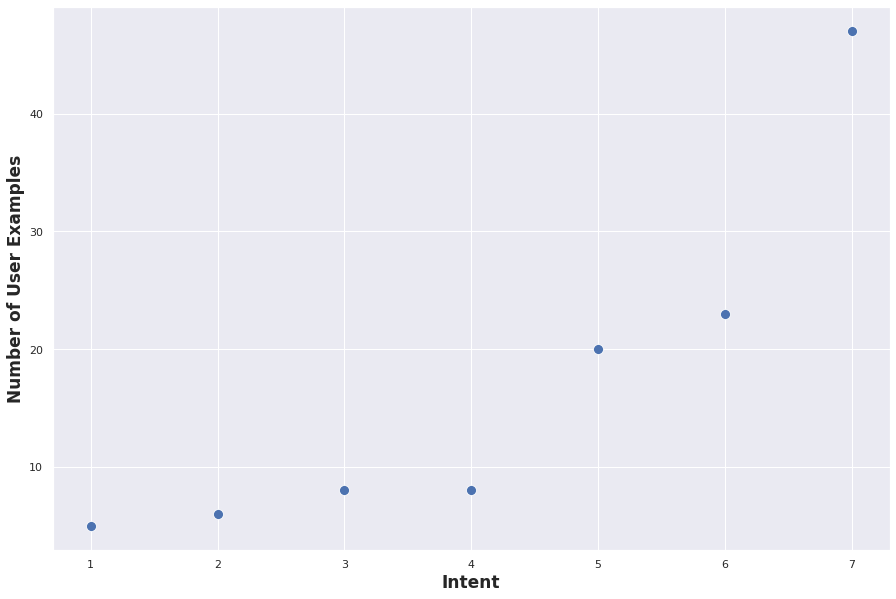

In [22]:
summary_generator.scatter_plot_intent_dist(workspace_pd)

In [23]:
summary_generator.show_user_examples_per_intent(workspace_pd)

### Sorted Distribution of User Examples per Intent

,Intent,Number of User Examples
1,Fallback,5
2,Goodbye,6
3,What can I do?,8
4,Thank you,8
5,Schedule An Appointment,20
6,Where are you located?,23
7,What are your hours?,47


### Actions for class imbalance<a id='actionimbalance'></a>

Class imbalance will not always lead to lower accuracy, which means that all intents (classes) do not need to have the same number of examples.

Given a hypothetical chatbot related to banking:<br>

- For intents like `updateBankAccount` and `addNewAccountHolder` where the semantics difference between them is subtler, the number of examples per intent needs to be somewhat balanced otherwise the classifier might favor the intent with the higher number of examples.
- For intents like `greetings` that are semantically distinct from other intents like `updateBankAccount`, it may be acceptable for it to have fewer examples per intent and still be easy for the intent detector to classify.



If the intent classification accuracy is lower than expected during testing, you should re-examine the distribution analysis.  

With regard to sorted distribution of examples per intent, if the sorted number of user examples varies a lot across different intents, it can be a potential source of bias for intent detection. Large imbalances in general should be avoided. This can potentially lead to lower accuracy. If your graph displays this characteristic, this could be a source of error.

For further guidance on adding more examples to help balance out your distribution, refer to 
<a href="https://cloud.ibm.com/docs/services/assistant?topic=assistant-intent-recommendations#intent-recommendations-get-example-recommendations" target="_blank" rel="noopener no referrer">Intent Example Recommendation</a>.

<a id='part1.4'></a>
## 1.4  Perform correlation analysis

- [Retrieve the most correlated unigrams and bigrams for each intent](#retrieve)
- [Actions for anomalous correlations](#anomalous)

### Retrieve the most correlated unigrams and bigrams for each intent<a id='retrieve'></a>

Perform a chi square significance test using count features to determine the terms that are most correlated with each intent in the data set. 

A `unigram` is a single word, while a `bigram` is two consecutive words from within the training data. For example, if you have a sentence like `Thank you for your service`, each of the words in the sentence are considered unigrams while terms like `Thank you`, `your service` are considered bigrams.

Terms such as `hi`, `hello` correlated with a `greeting` intent are reasonable. But terms such as `table`, `chair` correlated with the `greeting` intent are anomalous. A scan of the most correlated unigrams & bigrams for each intent can help you spot potential anomalies within your training data.

**Note**: We ignore the following common words (\"stop words\") from consideration `an, a, in, on, be, or, of, a, and, can, is, to, the, i`

In [24]:
unigram_intent_dict, bigram_intent_dict = chi2_analyzer.get_chi2_analysis(workspace_pd, lang_util=lang_util)

## Chi-squared Analysis

,Intent,Correlated Unigrams,Correlated Bigrams
1,What are your hours?,"time, close, hour, are, open","what time, what are, store open, you close, you open"
2,Where are you located?,"pleas, locat, where, find, get","find store, where are, get your, give me, how do"
3,Schedule An Appointment,"my, meet, face, make, appoint","come for, d like, like make, face face, make appoint"
4,Thank you,"mani, it, much, appreci, thank","you veri, mani thank, appreci it, much appreci, thank you"
5,What can I do?,"me, decid, say, assist, help","what do, what say, you assist, you help, help me"
6,Goodbye,"ciao, good, see, ya, bye","good bye, see ya, so long"
7,Fallback,"call, connect, human, speak, agent","agent help, call agent, connect agent, speak human, like speak"


### Actions for anomalous correlations<a id='anomalous'></a>

If you identify unusual or anomalous correlated terms such as: numbers, names and so on, which should not be correlated with an intent, consider the following:
  
- **Case 1** : If you see names appearing amongst correlated unigrams or bigrams, add more variation of names so no specific names will be correlated  
- **Case 2** : If you see specific numbers like 1234 amongst correlated unigrams or bigrams and these are not helpful to the use case, remove or mask these numbers from the examples
- **Case 3** : If you see terms which should never be correlated to that specific intent, consider adding or removing terms/examples so that domain specific terms are correlated with the correct intent

<a id='part1.5'></a>
## 1.5 Visualize terms using a heat map

- [Display term analysis for a custom intent list](#customintent)
- [Actions for anomalous terms in the heat map](#heatmap)

A heat map of terms is a method to visualize terms or words that frequently occur within each intent. Rows are the terms, and columns are the intents. 

The code below displays the top 30 intents with the highest number of user examples in the analysis. This number can be changed if needed.

## <p style="text-align: center;"> Token Frequency per Intent </p>

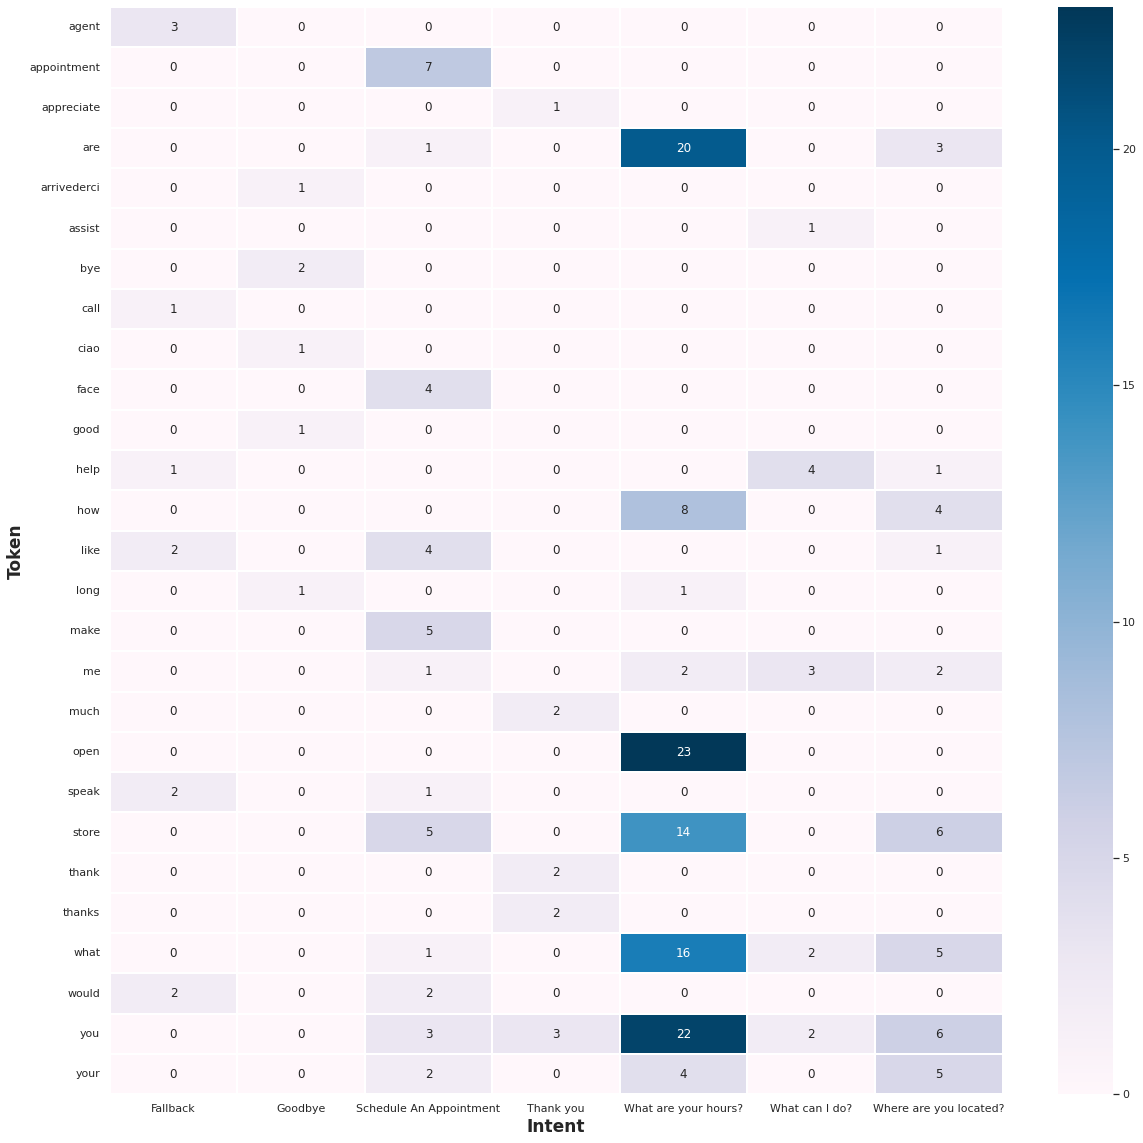

In [25]:
INTENTS_TO_DISPLAY = 30  # Total number of intents for display
MAX_TERMS_DISPLAY = 30  # Total number of terms to display

intent_list = []
keyword_analyzer.seaborn_heatmap(workspace_pd, lang_util, INTENTS_TO_DISPLAY, MAX_TERMS_DISPLAY, intent_list)

### Display term analysis for a custom intent list<a id='customintent'></a>

If you wish to see term analysis for specific intents, feel free to add those intents to the intent list. This generates a custom term heatmap. The code below displays the top 20 terms, but this can be changed if needed.

## <p style="text-align: center;"> Token Frequency per Intent </p>

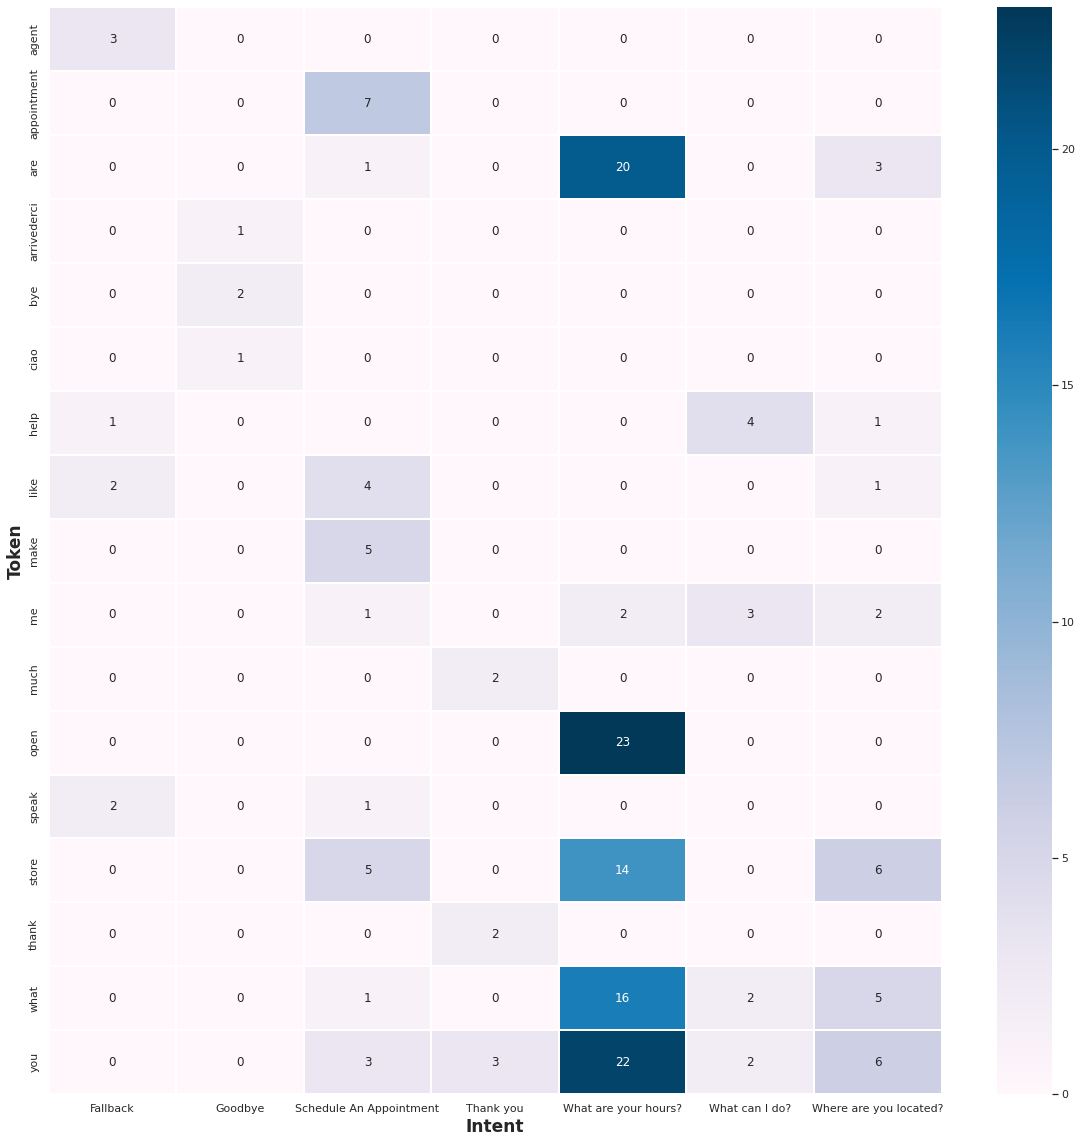

In [26]:
intent_list = workspace_pd['intent'].unique().tolist()
# intent_list = []
MAX_TERMS_DISPLAY = 20  # Total number of terms to display

if intent_list: 
    keyword_analyzer.seaborn_heatmap(workspace_pd, lang_util, INTENTS_TO_DISPLAY, MAX_TERMS_DISPLAY, intent_list)

### Actions for anomalous terms in the heat map<a id='heatmap'></a>

If you notice any terms or words which should not be frequently present within an intent, consider modifying examples in that intent.

<a id='part1.6'></a>
## 1.6 Ambiguity in the training data

- [Uncover ambiguous utterances across intents](#uncover)
- [Actions for ambiguity in the training data](#ambiguityaction)

Run the code blocks below to uncover possibly ambiguous terms based on feature correlation.

Based on the chi-square analysis above, generate intent pairs which have overlapping correlated unigrams and bigrams.
This allows you to get a glimpse of which unigrams or bigrams might cause potential confusion with intent detection:

#### A. Top intent pairs with overlapping correlated unigrams

In [27]:
ambiguous_unigram_df = chi2_analyzer.get_confusing_key_terms(unigram_intent_dict)

There is no ambiguity based on top 5 key terms in chi2 analysis

#### B. Top intent pairs with overlapping correlated bigrams

In [28]:
ambiguous_bigram_df = chi2_analyzer.get_confusing_key_terms(bigram_intent_dict)

There is no ambiguity based on top 5 key terms in chi2 analysis

#### C. Overlap checker for specific intents

In [29]:
# Add specific intent or intent pairs for which you would like to see overlap
intent1 = 'Where are you located?'
intent2 = 'Fallback'
chi2_analyzer.chi2_overlap_check(ambiguous_unigram_df,ambiguous_bigram_df,intent1,intent2)

### Uncover ambiguous utterances across intents<a id='uncover'></a>
The following analysis shows user examples that are similar but fall under different intents.  

In [30]:
similar_utterance_diff_intent_pd = similarity_analyzer.ambiguous_examples_analysis(workspace_pd, lang_util)

### There are no similar utterances within different Intent

### Actions for ambiguity in the training data<a id='ambiguityaction'></a>

**Ambiguous intent pairs**  
If you see terms which are correlated with more than 1 intent, review if this seems anomalous based on the use case for that intent. If it seems reasonable, it is probably not an issue.  

**Ambiguous utterances across intents** 
- **Duplicate utterances**: For duplicate or almost identical utterances, remove those that seem unnecessary.
- **Similar utterances**: For similar utterances, review the use case for those intents and make sure that they are not accidental additions caused by human error when the training data was created.  

For more information about entity, refer to the <a href="https://cloud.ibm.com/docs/services/assistant/services/assistant?topic=assistant-entities" target="_blank" rel="noopener no referrer">Entity Documentation</a>.

For more in-depth analysis related to possible conflicts in your training data across intents, try the conflict detection feature in Watson Assistant. Refer to <br> <a href="https://cloud.ibm.com/docs/services/assistant?topic=assistant-intents#intents-resolve-conflicts" target="_blank" rel="noopener no referrer">Conflict Resolution Documentation</a>.

<a id='part2'></a>
# Part 2: Prepare the test data

Analyze your existing Watson Assistant Action Skill with the help of a test set.

2.1. [Obtain test data from Cloud Object Storage](#cos)<br>
2.2. [Evaluate the test data](#evaluate) <br>
2.3. [Analyze the test data](#testanalysis) <br>

## 2.1 Obtain test data from Cloud Object Storage<a id='cos'></a>

Upload a test set in tsv format. Each line in the file should have only `User_Input<tab>Intent`  

For example:
```
hello how are you<tab>Greeting  
I would like to talk to a human<tab>AgentHandoff  
```

In [34]:
# this will re-use the previous cos bucket credentials
# please upload your test set to your COS bucket and input the file name here to download it

IBM_COS_FILE_KEY_TEST_SET = 'test_set.csv'
body = cos_client.get_object(Bucket=IBM_COS_BUCKET,Key=IBM_COS_FILE_KEY_TEST_SET)['Body']

#Separator: Use '\t' for tab separated data, ',' for comma separated data
separator = "\t"


test_df = skills_util.process_test_set(body, lang_util, separator, cos=True)

display(Markdown("### Random Test Sample"))
display(HTML(test_df.sample(n=min(10, len(test_df))).to_html(index=False)))

### Random Test Sample

utterance,intent,tokens
i prefer a face to face visit customer care appointments,SYSTEM_OUT_OF_DOMAIN,"[i, prefer, a, face, to, face, visit, custom, care, appoint]"
are you open on sunday customer care store hours,SYSTEM_OUT_OF_DOMAIN,"[are, you, open, on, sunday, custom, care, store, hour]"
are you open on sundays and if so what are the hours customer care store hours,SYSTEM_OUT_OF_DOMAIN,"[are, you, open, on, sunday, and, if, so, what, are, the, hour, custom, care, store, hour]"
what are your hours customer care store hours,SYSTEM_OUT_OF_DOMAIN,"[what, are, your, hour, custom, care, store, hour]"
find store customer care store location,SYSTEM_OUT_OF_DOMAIN,"[find, store, custom, care, store, locat]"
cancel the request cancel,SYSTEM_OUT_OF_DOMAIN,"[cancel, the, request, cancel]"
hey twin general greetings,SYSTEM_OUT_OF_DOMAIN,"[hey, twin, general, greet]"
thank you thanks,SYSTEM_OUT_OF_DOMAIN,"[thank, you, thank]"
do not want a robot general connect to agent,SYSTEM_OUT_OF_DOMAIN,"[do, not, want, a, robot, general, connect, to, agent]"
what time are you closing today customer care store hours,SYSTEM_OUT_OF_DOMAIN,"[what, time, are, you, close, today, custom, care, store, hour]"


## 2.2 Evaluate the test data<a id='evaluate'></a>
These steps can take time if you have a large test set.  

**<font color=red>Note</font>**: You will be charged for calls made from this notebook based on your Watson Assistant plan. The user_id will be the same for all message calls.

In [35]:
# Change Assistant API version if needed
# Find Latest --> https://cloud.ibm.com/apidocs/assistant-v2#versioning
API_VERSION = '2021-11-27'

# For ICP(IBM Cloud Private), you can disable SSL verification by changing this to True
DISABLE_SSL_VERTIFICATION = False 

conversation = skills_util.retrieve_conversation(iam_apikey=iam_apikey,
                                                 url=URL,
                                                 api_version=API_VERSION,
                                                 authenticator_url=authenticator_url,
                                                 sdk_version="V2", # DO NOT CHANGE THIS ARG
                                                )


# conversation = skills_util.retrieve_conversation(username=username,
#                                              password=password,                                                       
#                                              url=URL,
#                                              api_version=API_VERSION,
#                                              sdk_version="V2", # DO NOT CHANGE THIS ARG
#                                              )


conversation.set_disable_ssl_verification(DISABLE_SSL_VERTIFICATION)

In [36]:
THREAD_NUM = min(4, os.cpu_count() if os.cpu_count() else 1)

full_results = inferencer.inference(conversation,
                                    test_df,
                                    max_thread=THREAD_NUM, 
                                    assistant_id=ASSISTANT_ID,
                                    intent_to_action_mapping=intent_to_action_mapping
                                   )

100%|██████████| 53/53 [00:02<00:00, 23.59it/s]


<a id='part2.1'></a>
## 2.3 Analyze the test data<a id='testanalysis'></a>

- [Display an overview of the test data](#overview)
- [Compare the test data and the training data](#compare)
- [Determine the overall accuracy on the test set](#accuracy)
- [Analyze the errors](#errors)

### Display an overview of the test data<a id='overview'></a>

In [37]:
summary_generator.generate_summary_statistics(test_df)
summary_generator.show_user_examples_per_intent(test_df)

### Summary Statistics

,Data Characteristic,Value
1,Total User Examples,53
2,Unique Intents,1
3,Average User Examples per Intent,53
4,Standard Deviation from Average,0
5,Total Number of Entities,0


### Sorted Distribution of User Examples per Intent

,Intent,Number of User Examples
1,SYSTEM_OUT_OF_DOMAIN,53


### Compare the test data and the training data<a id='compare'></a>

Ideally the test and training data distributions should be similar. The following metrics can help identify gaps between the test set and the training set:

**1.**  The distribution of user examples per intent for the test data should be comparable to the training data   
**2.**  The average length of user examples for test and training data should be comparable to the training data <br>
**3.**  The vocabulary and phrasing of utterances in the test data should be comparable to the training data

If your test data comprises of examples labelled from your logs, and the training data comprises of examples created by human subject matter experts, there may be discrepancies between what the virtual assistant designers thought the end users would type and the way they actually type in production. Thus, if you find discrepancies in this section, consider changing your design to resemble the way in which end users use your system more closely.

**<font color=red>Note</font>**: You will be charged for calls made from this notebook  based on your WA plan. The user_id will be the same for all message calls.

In [38]:
divergence_analyzer.analyze_train_test_diff(workspace_pd, test_df, full_results)

## Test Data Evaluation

### Missing Intents in Test Data

,Missing Intents in Test Set
1,What are your hours?
2,Where are you located?
3,Schedule An Appointment
4,Thank you
5,What can I do?
6,Goodbye
7,Fallback


### Test Data Example Length

Average length of user examples is comparable

### Vocabulary Size Test vs Train

,Train Vocabulary Size,Test Vocabulary Size,% Test Set Vocabulary not found in Train
1,158,134,35.07


### Determine the overall accuracy on the test set<a id='accuracy'></a>

In [39]:
results = full_results[['correct_intent', 'top_confidence','top_intent','utterance']]
accuracy = inferencer.calculate_accuracy(results)
display(Markdown("### Accuracy on Test Data: {} %".format(accuracy)))

### Accuracy on Test Data: 77.36 %

### Analyze the errors<a id='errors'></a>

This section gives you an overview of the errors made by the intent classifier on the test set.  

**Note**: `System Out of Domain` labels are assigned to user examples which get classified with confidence scores less than 0.2 as Watson Assistant considers them to be irrelevant.

In [40]:
wrongs_df = inferencer.calculate_mistakes(results)
display(Markdown("### Intent Detection Mistakes"))
display(Markdown("Number of Test Errors: {}".format(len(wrongs_df))))

with pd.option_context('max_colwidth', 250):
    if not wrongs_df.empty:
        display(wrongs_df)

### Intent Detection Mistakes

Number of Test Errors: 12

,correct_intent,top_confidence,top_intent,utterance
Test Example Index,,,,
2,SYSTEM_OUT_OF_DOMAIN,0.205000,Fallback,ciao goodbye
23,SYSTEM_OUT_OF_DOMAIN,0.306629,Fallback,can you help help
24,SYSTEM_OUT_OF_DOMAIN,0.344230,Fallback,help help
31,SYSTEM_OUT_OF_DOMAIN,1.000000,Fallback,can i talk to someone general connect to agent
32,SYSTEM_OUT_OF_DOMAIN,1.000000,Fallback,please connect me to a live agent general connect to agent
33,SYSTEM_OUT_OF_DOMAIN,1.000000,Fallback,where is the closest agent general connect to agent
34,SYSTEM_OUT_OF_DOMAIN,1.000000,Fallback,please assist me to get to an agent general connect to agent
35,SYSTEM_OUT_OF_DOMAIN,1.000000,Fallback,can i speak with somebody general connect to agent
37,SYSTEM_OUT_OF_DOMAIN,1.000000,Fallback,i want to speak to a human general connect to agent


<a id='part3'></a>
# Part 3: Perform advanced analysis

3.1 [Perform analysis using confidence thresholds](#part3.1)<br>
3.2 [Highlighting term importance](#part3.2)<br>
3.3 [Analyzing abnormal confidence levels](#part3.3)<br>


<a id='part3.1'></a>
## 3.1 Perform analysis using  confidence thresholds

This analysis illustrates how a confidence threshold is used to determine which data considered irrelevant or out of domain can be used for analysis. 

In [41]:
analysis_df= confidence_analyzer.analysis(results,None)

### Threshold Metrics

We calculate metrics for responses where the top intent has a confidence above the         threshold specified on the x-axis.  

We consider examples which are within the scope of the chatbot's problem formulation as          on topic or in domain and those examples which are outside the scope of the problem to be          out of domain or irrelevant

#### 1) Thresholded On Topic Accuracy (TOA)

x-axis: Confidence threshold used || y-axis: Intent Detection Accuracy for On Topic utterances

#### 2)  Bot Coverage %

x-axis: Confidence threshold used || y-axis: Fraction of All utterances above the threshold

#### 3) False Acceptance Rate for Out of Domain Examples (FAR)

x-axis: Confidence threshold used || y-axis: Fraction of Out of Domain utterances falsely considered on topic

#### Note: Default acceptance threshold for Watson Assistant is set at 0.2.        Utterances with top intent confidence < 0.2 will be considered irrelevant

**Inadequate Data Points**: No analysis will be conducted

<a id='part3.2'></a>
## 3.2 Highlight term importance

This intent can be ground-truth or an incorrectly predicted intent. It provides term level insights about which terms the classifier thought were important in relation to that specific intent.

Even if the system predicts an intent correctly, the terms which the intent classifier thought were important may not be as expected by human insight. Human insight might suggest that the intent classifier is focusing on the wrong terms.  

The score of each term in the following highlighted images can be viewed as importance factor of that term for that specific intent. The larger the score, the more important the term.

You can get the highlighted images for either wrongly-predicted utterances or utterances where the classifier returned a low confidence.   

**<font color=red>Note</font>**: You will be charged for calls made from this notebook  based on your WA plan. The user_id will be the same for all message calls.

### Identified 1 problematic utterances 

100%|██████████| 8/8 [00:00<00:00, 24.16it/s]


1 examples are shown below:

,Characteristic,Value
1,Test Set Index,0
2,Utterance,what can i do to talk to someone
3,Actual Intent,Schedule An Appointment
4,Predicted Intent,Fallback
5,Confidence,0.204452


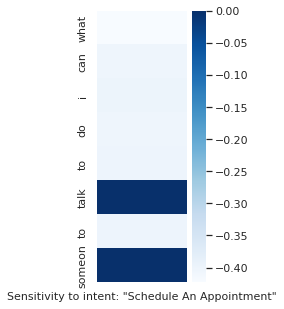

In [42]:
# Pick an example from section 1 which was misclassified
# Add the example and correct intent for the example
utterance = "what can i do to talk to someone"  # input example
intent = "Schedule An Appointment"  # input an intent in your workspace which you are interested in.


inference_results = inferencer.inference(conversation=conversation, 
                                         test_data=pd.DataFrame({'utterance':[utterance], 
                                                                 'intent':[intent]}), 
                                         max_thread = 1, 
                                         assistant_id=ASSISTANT_ID,
                                         intent_to_action_mapping=intent_to_action_mapping,
                                        )

highlighter.get_highlights_in_batch_multi_thread(conversation=conversation, 
                                                 full_results=inference_results, 
                                                 output_folder=None,
                                                 confidence_threshold=1,
                                                 show_worst_k=1,
                                                 lang_util=lang_util,
                                                 assistant_id=ASSISTANT_ID,
                                                 intent_to_action_mapping=intent_to_action_mapping,
                                                )

In the section below you analyze your test results and produce highlighting for the top 25 problematic utterances which were either mistakes or had confidences below the threshold that was set.    

**<font color=red>Note</font>**: You will be charged for calls made from this notebook  based on your WA plan. The user_id will be the same for all message calls.

### Identified 12 problematic utterances 

100%|██████████| 97/97 [00:02<00:00, 33.54it/s]


25 examples are shown below:

,Characteristic,Value
1,Test Set Index,31
2,Utterance,can i talk to someone general connect to agent
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Fallback
5,Confidence,1.0


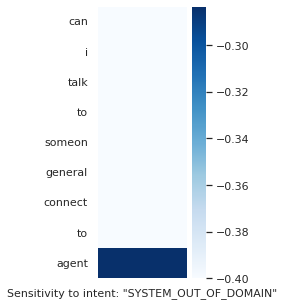

,Characteristic,Value
1,Test Set Index,32
2,Utterance,please connect me to a live agent general connect to agent
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Fallback
5,Confidence,1.0


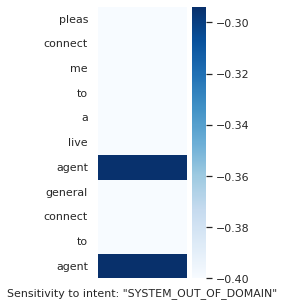

,Characteristic,Value
1,Test Set Index,33
2,Utterance,where is the closest agent general connect to agent
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Fallback
5,Confidence,1.0


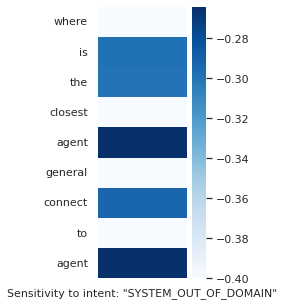

,Characteristic,Value
1,Test Set Index,34
2,Utterance,please assist me to get to an agent general connect to agent
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Fallback
5,Confidence,1.0


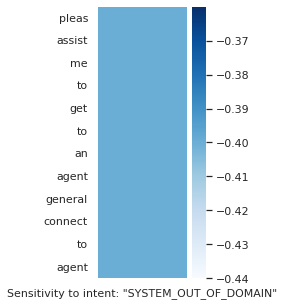

,Characteristic,Value
1,Test Set Index,35
2,Utterance,can i speak with somebody general connect to agent
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Fallback
5,Confidence,1.0


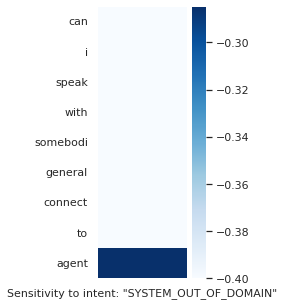

,Characteristic,Value
1,Test Set Index,37
2,Utterance,i want to speak to a human general connect to agent
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Fallback
5,Confidence,1.0


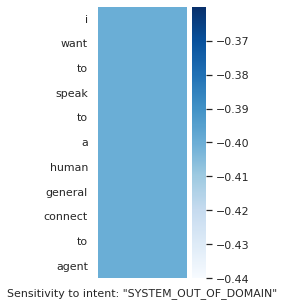

,Characteristic,Value
1,Test Set Index,39
2,Utterance,can i connect to an agent general connect to agent
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Fallback
5,Confidence,1.0


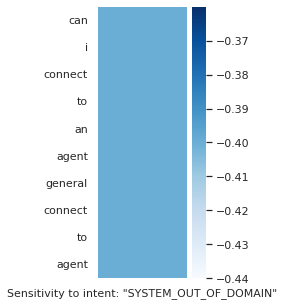

,Characteristic,Value
1,Test Set Index,40
2,Utterance,can you please transition my conversation to a human general connect to agent
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Fallback
5,Confidence,0.494145


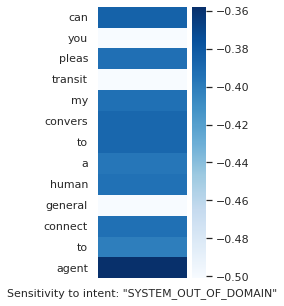

,Characteristic,Value
1,Test Set Index,38
2,Utterance,representative general connect to agent
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Fallback
5,Confidence,0.46092


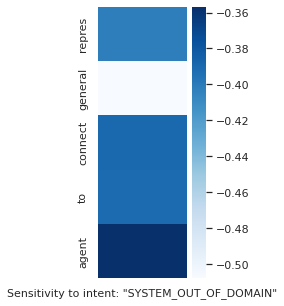

,Characteristic,Value
1,Test Set Index,24
2,Utterance,help help
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Fallback
5,Confidence,0.34423


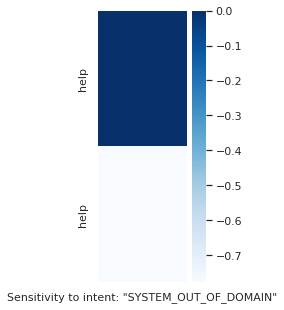

,Characteristic,Value
1,Test Set Index,23
2,Utterance,can you help help
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Fallback
5,Confidence,0.306629


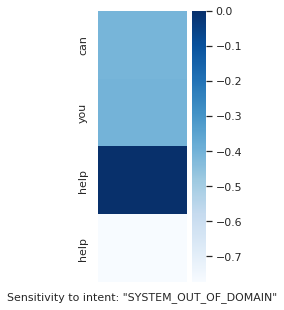

,Characteristic,Value
1,Test Set Index,2
2,Utterance,ciao goodbye
3,Actual Intent,SYSTEM_OUT_OF_DOMAIN
4,Predicted Intent,Fallback
5,Confidence,0.205


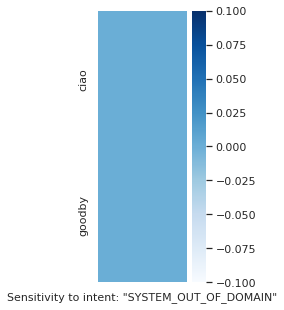

In [43]:
# The output folder for generated images
# Note modify this if you want the generated images to be stored in a different directory

highlighting_output_folder = './highlighting_images/'
if not os.path.exists(highlighting_output_folder):
    os.mkdir(highlighting_output_folder)

# The threshold the prediction needs to achieve below which  
# it will be considered as `out of domain` or `offtopic` utterances. 
threshold = 0.2

# Maximum number of test set examples whose highlighting analysis will be conducted
K=25
highlighter.get_highlights_in_batch_multi_thread(conversation=conversation, 
                                                 full_results=full_results, 
                                                 output_folder=highlighting_output_folder,
                                                 confidence_threshold=threshold,
                                                 show_worst_k=K,
                                                 lang_util=lang_util,
                                                 assistant_id=ASSISTANT_ID,
                                                 intent_to_action_mapping=intent_to_action_mapping,
                                                )

<a id='part3.3'></a>
## 3.3 Analyze abnormal confidence levels
Every test utterance is classified as a specific intent with a specific confidence by the Watson Assistant intent classifier. It is expected that model would be confident when it correctly predicts examples and not highly confident when it incorrectly predicts examples. 

But this is not always true. This can be because there are anomalies in the design. Examples that are predicted correctly with low confidence and the examples that are predicted incorrectly with high confidence are cases which need to be reviewed.

In [44]:
correct_thresh, wrong_thresh = 0.3, 0.7
correct_with_low_conf_list, incorrect_with_high_conf_list = confidence_analyzer.abnormal_conf(
    full_results, correct_thresh, wrong_thresh)

In [47]:
if len(correct_with_low_conf_list) > 0:
    display(Markdown("#### Examples correctedly predicted with low confidence"))
    with pd.option_context('max_colwidth', 250):
        display(HTML(correct_with_low_conf_list.to_html(index=False)))

In [48]:
if len(incorrect_with_high_conf_list) > 0:
    display(Markdown("#### Examples incorrectedly predicted with high confidence"))
    with pd.option_context('max_colwidth', 250):
        display(HTML(incorrect_with_high_conf_list.to_html(index=False)))

### Actions to take when you have examples of abnormal confidence

If there are examples which are incorrectly classified with high confidence for specific intents, it may indicate an issue in the design of those specific intents because the user examples provided for that intent may be overlapping with the design of other intents.

If intent A seems to always get misclassified as intent B with high confidence or gets correctly predicted with low confidence, consider using intent conflict detection. For more information, refer to the <a href="https://cloud.ibm.com/docs/services/assistant?topic=assistant-intents#intents-resolve-conflicts" target="_blank" rel="noopener no referrer">Conflict Resolution Documentation</a>.

Also consider whether those two intents need to be two separate intents or whether they need to be merged. If they can't be merged, then consider adding more user examples which distinguish intent A specifically from intent B.

<a id='part4'></a>
## Part 4: Summary
Congratulations! You have successfully completed the action skill analysis training. <br>
This notebook is designed to improve our action skill analysis in an iterative fashion. Use it to tackle one aspect of your action skill at a time and start over for another aspect later for continuous improvement.

##  Glossary

**True Positives (TP):** True Positive measures the number of correctly predicted positive values meaning that predicted class is the same as the actual class which is the target intent.

**True Negatives (TN):** True Negative measures the number of correctly predicted negative values meaning that the predicted class is the same as the actual class which is not the target intent.

**False Positives (FP):** False Positive measures the number of incorrectly predicted positive values meaning that the predicted class is the target intent but the actual class is not the target intent.  

**False Negatives (FN):** False Negatives measures the number of incorrectly predicted negative values meaning that the predicted class is not the target intent but the actual class is the target intent. 

**Accuracy:** Accuracy measures the ratio of corrected predicted user examples out of all user examples.   
Accuracy = (TP + TN) / (TP + TN + FP + FN)  

**Precision:** Precision measures the ratio of correctly predicted positive observations out of total predicted positive observations.   
Precision = TP / (TP + FP)  

**Recall:** Recall measures the ratio of correctly predicted positive observations out of all observations of the target intent.  
Recall = TP / (TP + FN)

**F1 Score:** F1 Score is the harmonic average of Precision and Recall.  
F1 = 2 \* (Precision \* Recall)/ (Precision + Recall)

For more information related to Watson Assistant, refer to the <a href="https://cloud.ibm.com/docs/services/assistant" target="_blank" rel="noopener no referrer">Watson Assistant Documentation</a>.

# <hr>
Copyright © 2022 IBM. This notebook and its source code are released under the terms of the MIT License.